In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
iq_brains  = [44, 52, 42, 66, 53, 42, 55, 57, 56, 51]
iq_regular = [55, 44, 34, 18, 51, 40, 40, 49, 48, 46]

In [4]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.1


In [27]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    mu_brains  = pm.TruncatedNormal("mu_brains",  mu = 50, sigma = 10, lower = 0)
    mu_regular = pm.TruncatedNormal("mu_regular", mu = 50, sigma = 10, lower = 0)
    sigma      = pm.TruncatedNormal("sigma",      mu = 10, sigma =  5, lower = 0)
    df         = pm.Uniform("df", 
                            lower = 1, 
                            upper = max(len(iq_brains), len(iq_regular))-1)

    # Likelihood (sampling distribution) of observations
    iq_brains_obs  = pm.StudentT("iq_brains", 
                                 nu = df, mu = mu_brains, sigma = sigma, 
                                 observed = iq_brains)
    iq_regular_obs = pm.StudentT("iq_regular", 
                                 nu = df, mu = mu_regular, sigma = sigma, 
                                 observed = iq_regular)

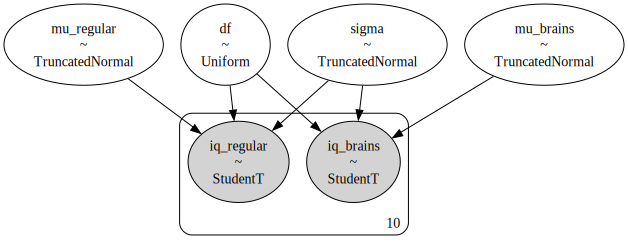

In [28]:
pm.model_to_graphviz(basic_model)

In [29]:
with basic_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [df, iq_brains, iq_regular, mu_brains, mu_regular, sigma]


In [32]:
prior_samples.prior_predictive["iq_brains"].shape

(1, 100, 10)

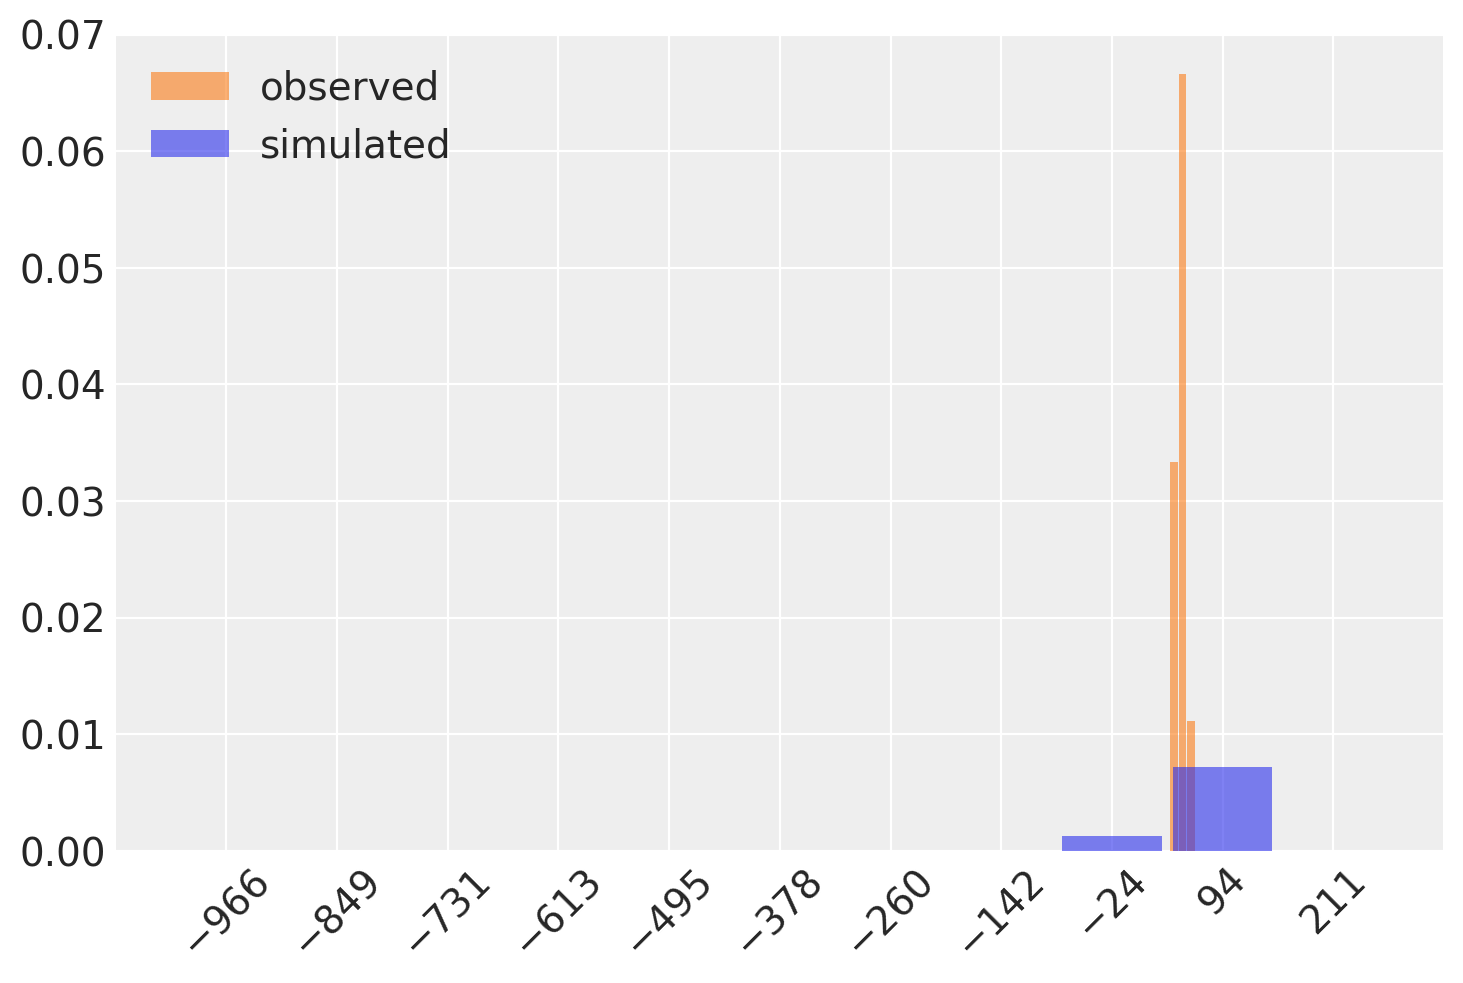

In [30]:
az.plot_dist(
    iq_brains,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["iq_brains"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

In [33]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_brains, mu_regular, sigma, df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


In [7]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

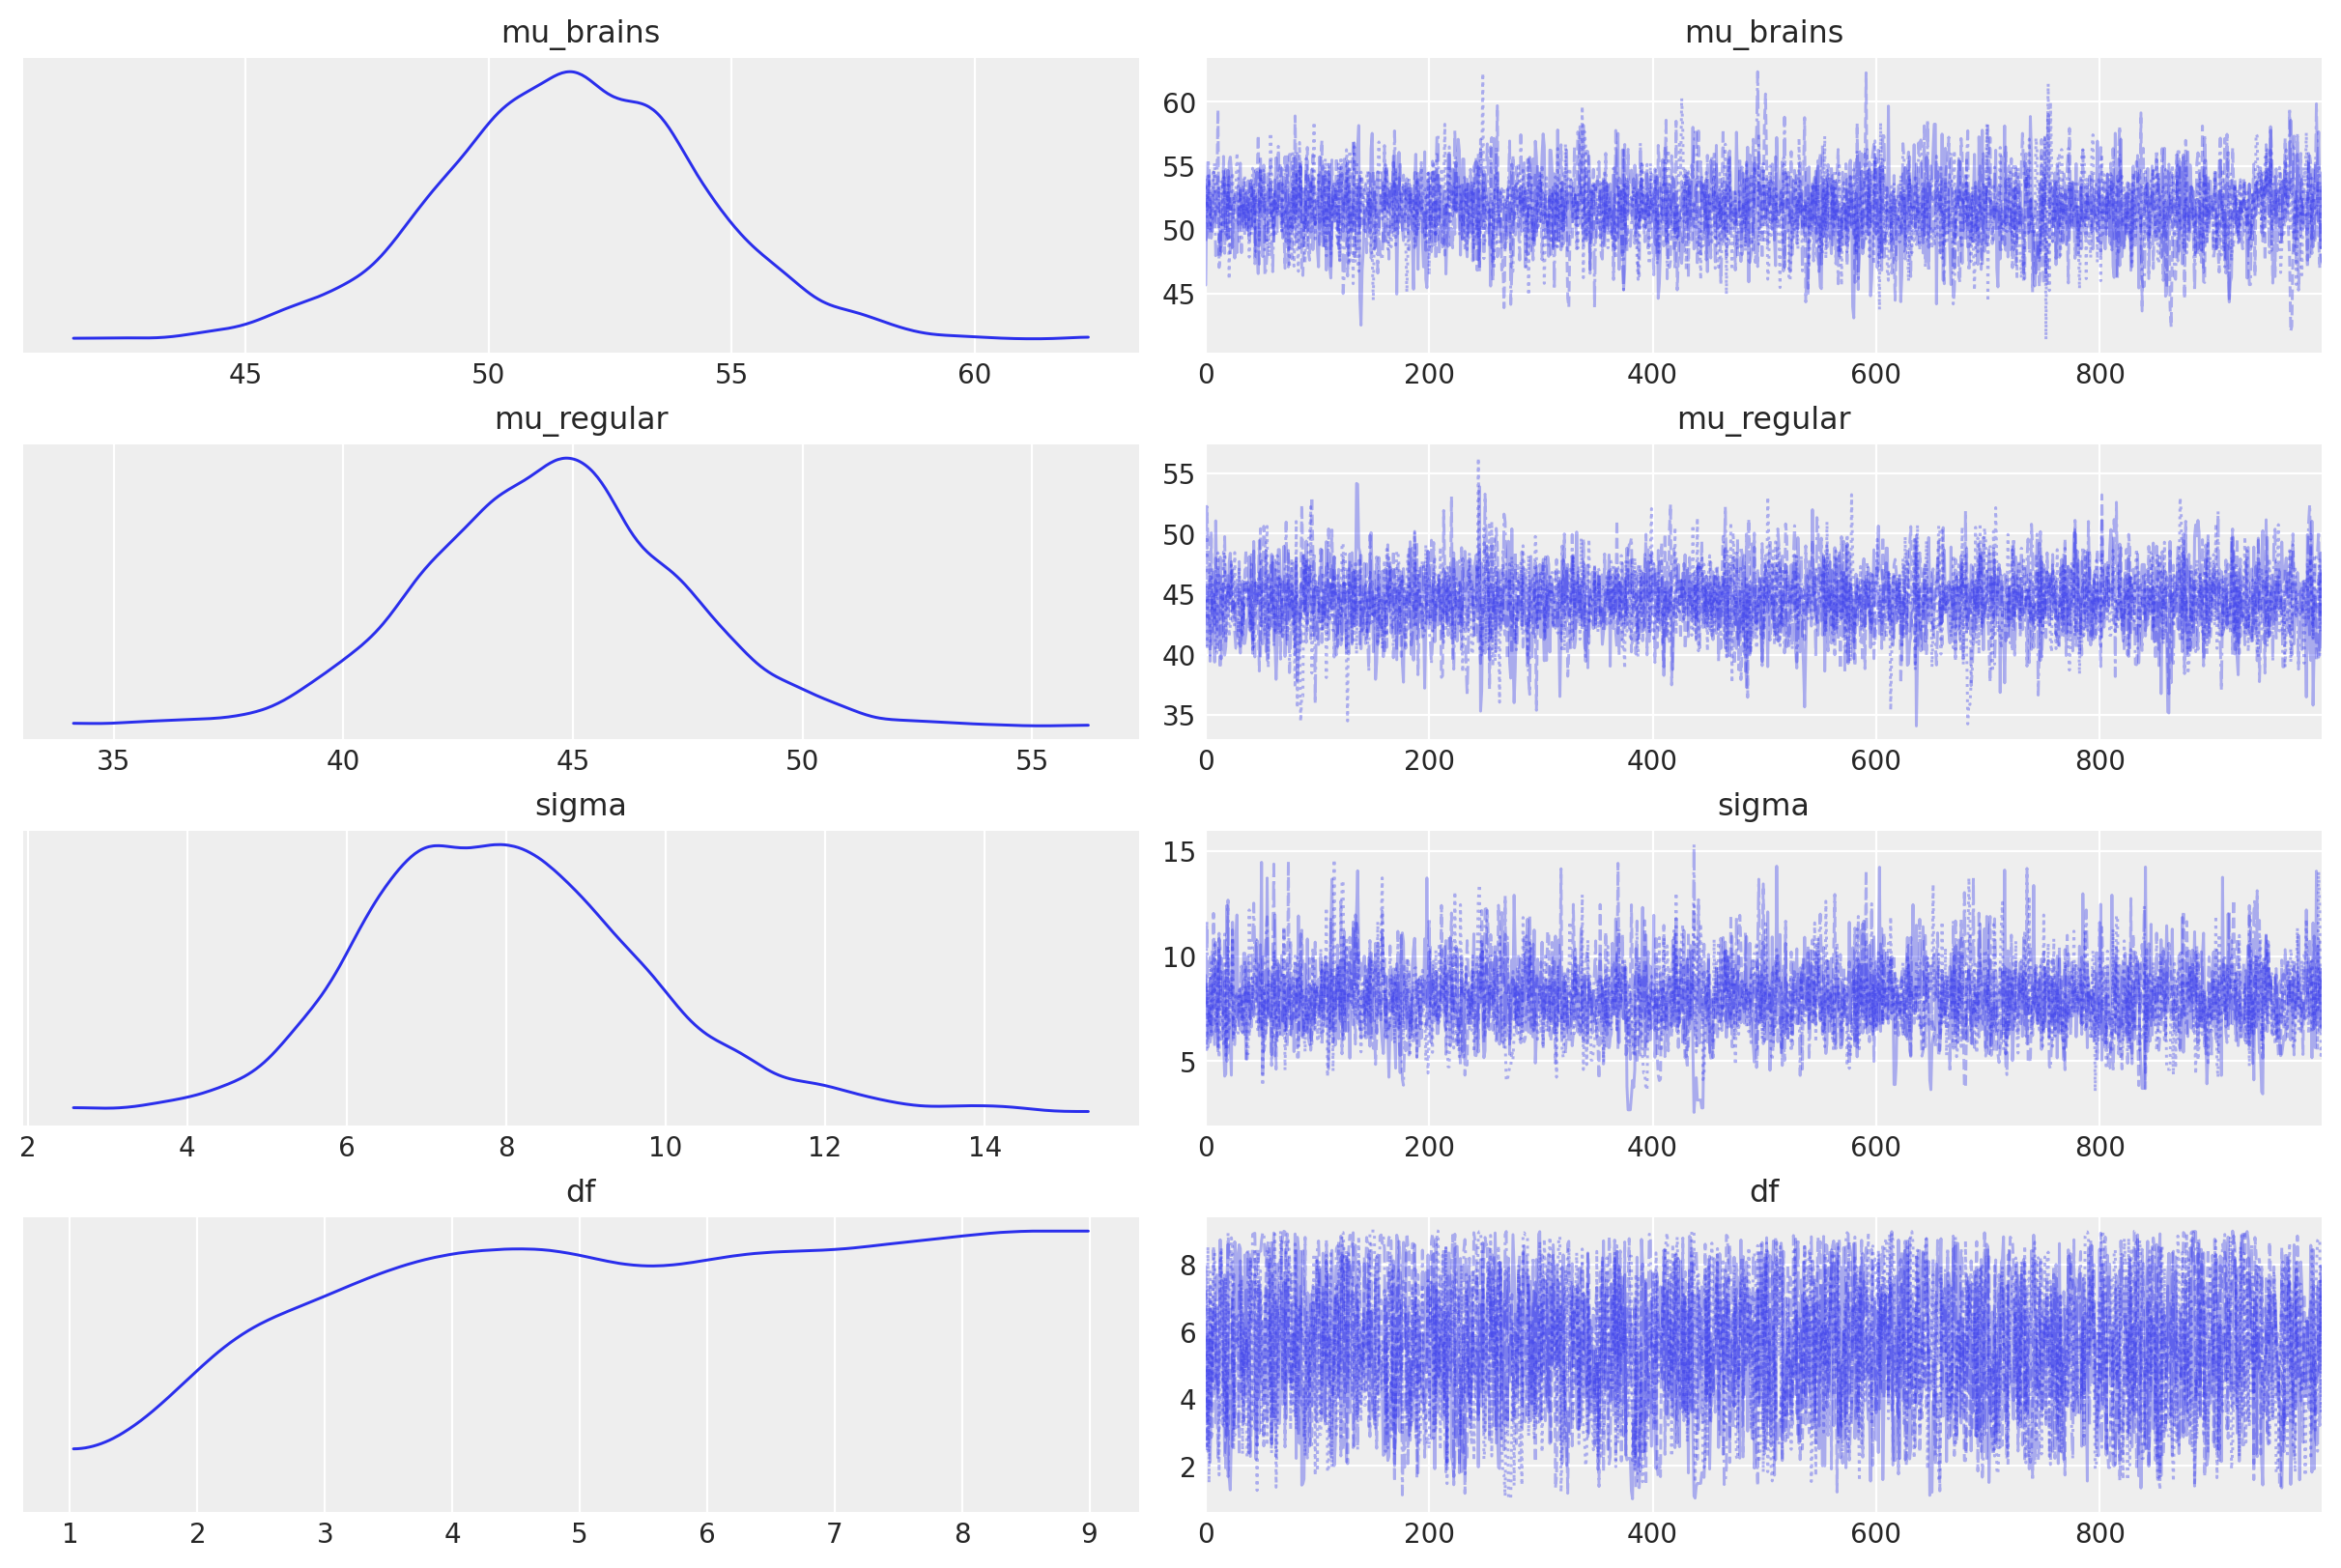

In [34]:
az.plot_trace(idata, combined=True);

In [35]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_brains,51.66,2.70,46.17,56.49,0.04,0.03,3705.92,3125.27,1.0
mu_regular,44.49,2.78,39.38,49.79,0.04,0.03,4063.00,2928.69,1.0
sigma,7.97,1.77,4.60,11.23,0.03,0.02,2525.11,1732.81,1.0
df,5.54,2.09,2.23,9.00,0.04,0.03,2269.47,1896.06,1.0


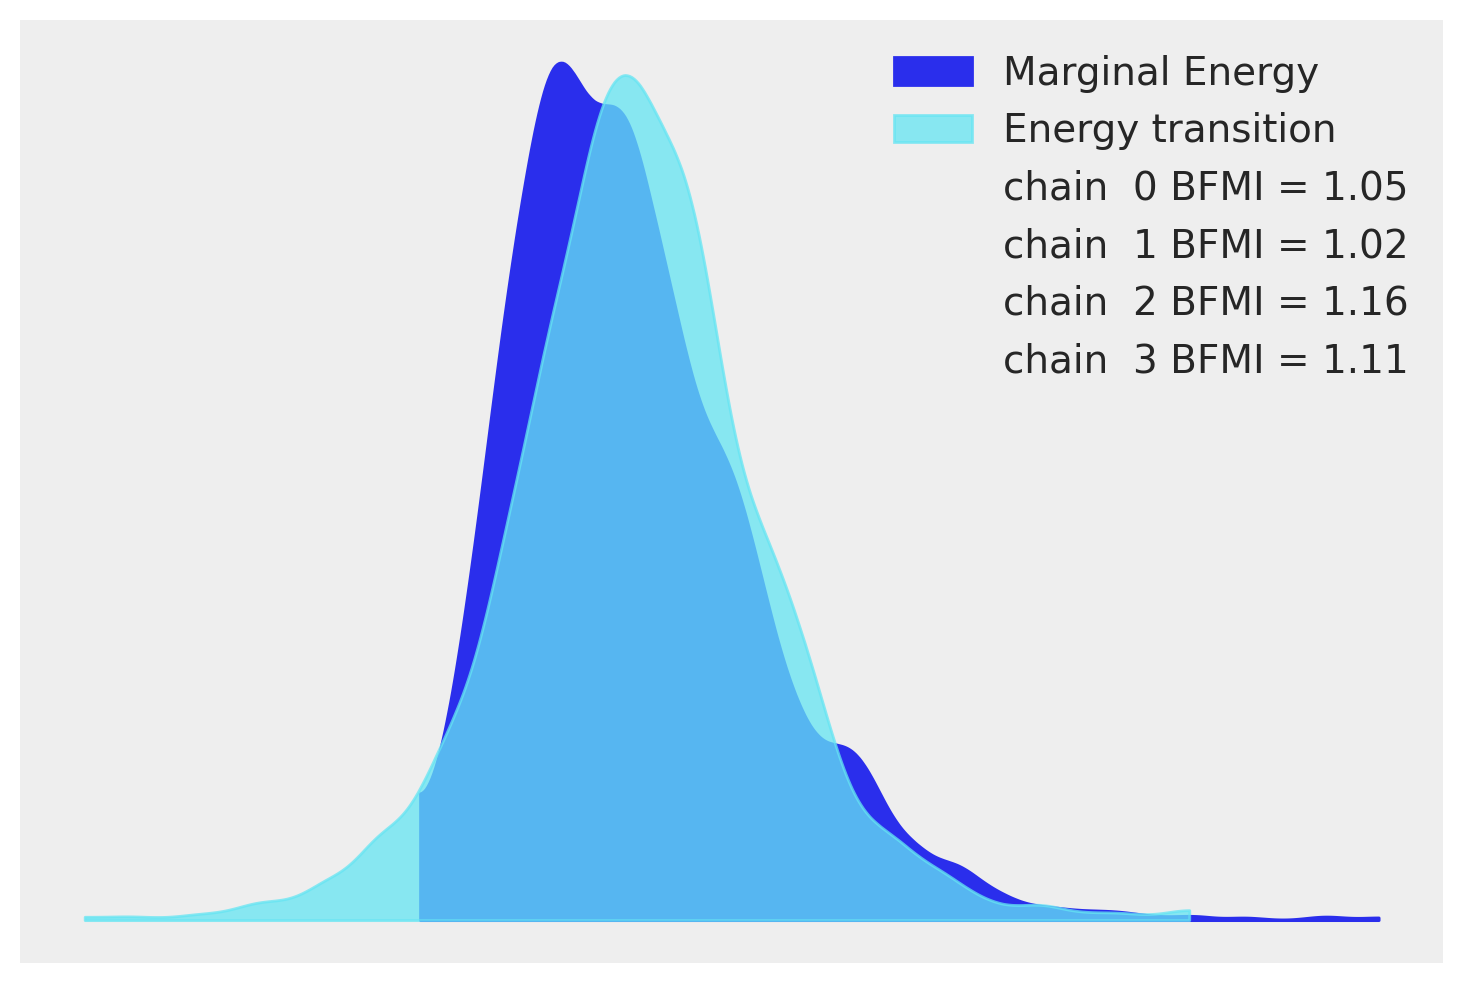

In [36]:
az.plot_energy(idata);

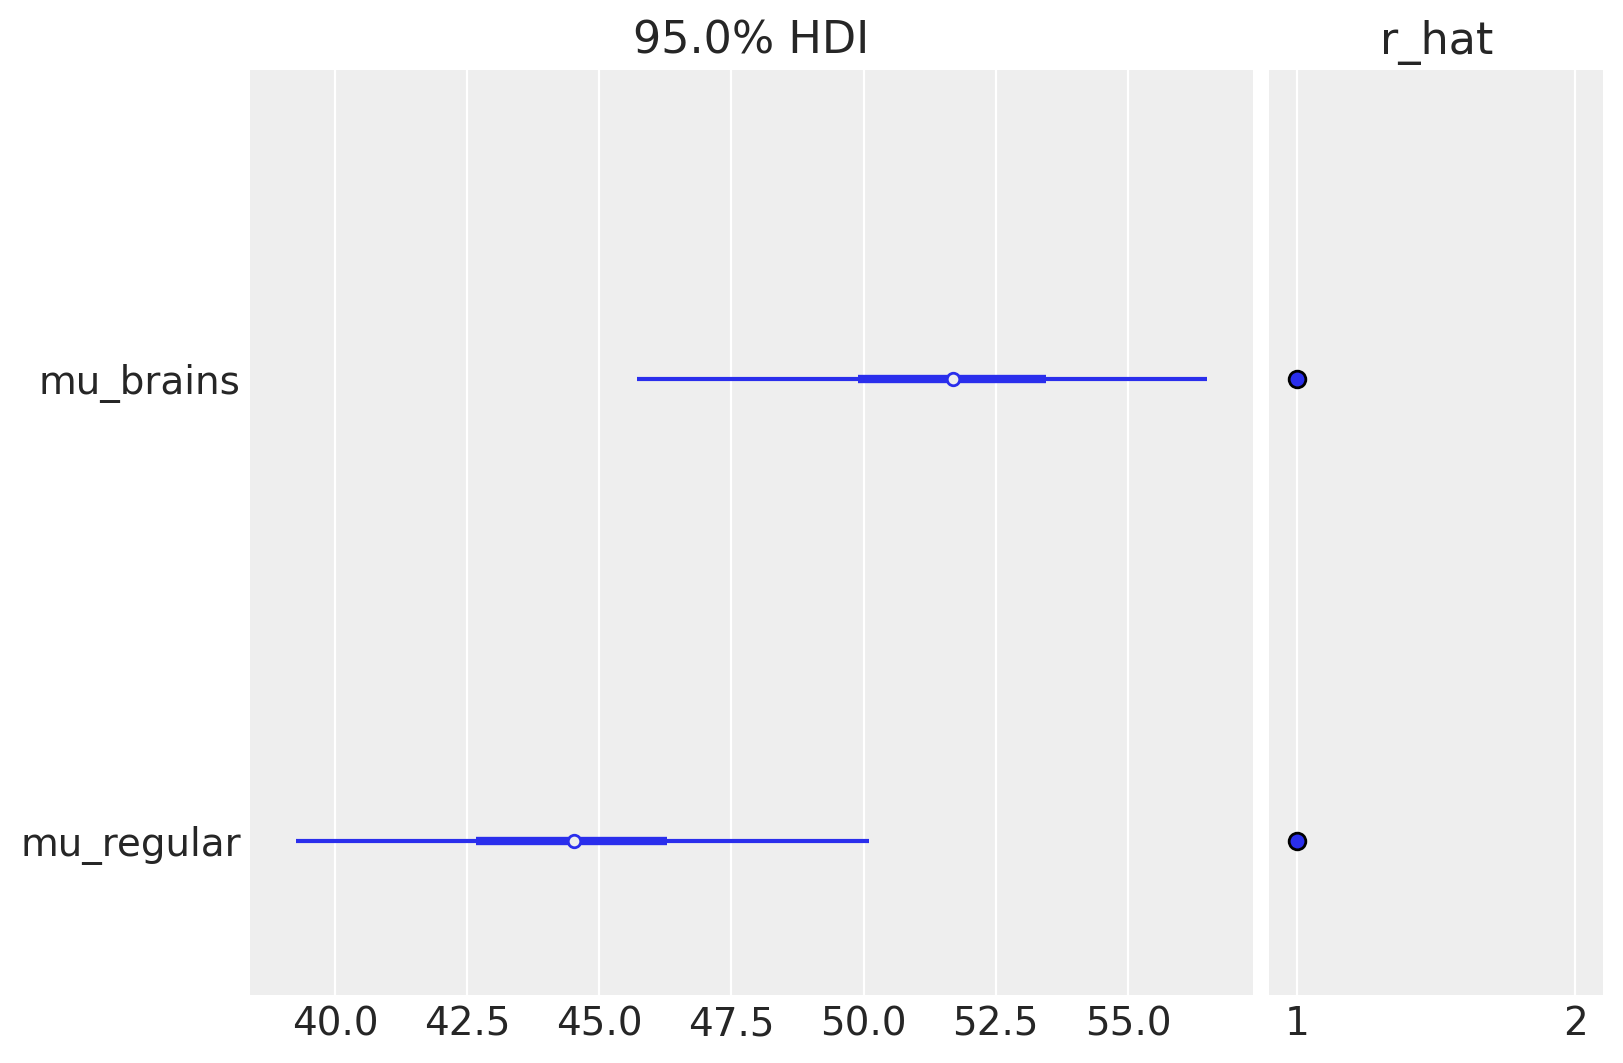

In [38]:
az.plot_forest(idata, var_names=["mu_brains", "mu_regular"], combined=True, hdi_prob=0.95, r_hat=True);

In [46]:
idata.posterior[["mu_brains", "mu_regular"]].to_dataframe()

mu_brains  mu_regular
chain draw                       
0     0     45.686507   44.396091
      1     52.688382   40.786332
      2     54.212127   44.531237
      3     49.390722   45.074118
      4     52.577951   46.486563
...               ...         ...
3     995   53.608803   48.509582
      996   50.548423   50.189589
      997   51.137064   39.884229
      998   48.484165   46.939698
      999   47.456985   44.663189

[4000 rows x 2 columns]